# OTTO EDA

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
# timestamp converted
# train = pd.read_parquet('./input/train.parquet')
# test = pd.read_parquet('./input/test.parquet')
train = pd.read_parquet('./input/train_datetime.parquet')
test = pd.read_parquet('./input/test_datetime.parquet')
train.head()

,session,aid,ts,type
0,0,1517085,1659304800,0
1,0,1563459,1659304904,0
2,0,1309446,1659367439,0
3,0,16246,1659367719,0
4,0,1781822,1659367871,0


# OVERVIEW

In [3]:
# min and max dates
# German timezone UTC+2 https://www.kaggle.com/competitions/otto-recommender-system/discussion/367991
train.ts = pd.to_datetime(train.ts * 1e9) + timedelta(hours=2)
test.ts = pd.to_datetime(test.ts * 1e9) + timedelta(hours=2)
print('Train min date and max date are:', train.ts.min(),'and', train.ts.max() )
print('Test min date and max date are:', test.ts.min(),'and', test.ts.max() )

Train min date and max date are: 2022-08-01 00:00:00 and 2022-08-28 23:59:59
Test min date and max date are: 2022-08-29 00:00:00 and 2022-09-04 23:59:51


In [4]:
# train.to_parquet('./input/train_datetime.parquet')
# test.to_parquet('./input/test_datetime.parquet')

In [6]:
sess_start_ts = train.groupby("session")['ts'].min()
val_sess = sess_start_ts[sess_start_ts >= "2022-08-22 00:00:00"].index.tolist()
df = train.loc[~train.session.isin(val_sess)].reset_index(drop=True)
df = df.loc[train.ts < "2022-08-22 00:00:00"].reset_index(drop=True)
df.head()

,session,aid,ts,type
0,0,1517085,2022-08-01 00:00:00,0
1,0,1563459,2022-08-01 00:01:44,0
2,0,1309446,2022-08-01 17:23:59,0
3,0,16246,2022-08-01 17:28:39,0
4,0,1781822,2022-08-01 17:31:11,0


In [5]:
# COMPUTE DAY AND HOUR OF ACTIVITY
train['day'] = train.ts.dt.day
train['hour'] = train.ts.dt.hour
train = train.reset_index(drop=True)

test['day'] = test.ts.dt.day + (test.ts.dt.month - 8) * 31
test['hour'] = test.ts.dt.hour
test = test.reset_index(drop=True)

tmp = train.groupby('session').aid.agg('count').rename('n')
train = train.merge(tmp,on='session')
tmp = test.groupby('session').aid.agg('count').rename('n')
test = test.merge(tmp,on='session')
frequent_users = train.loc[train.n>40,'session'].unique()
print(f"There are {len(frequent_users)} users whom each have over 40 item interactions in our truncated train data sample.")

There are 1231956 users whom each have over 40 item interactions in our truncated train data sample.


In [6]:
train.aid.nunique()

1855603

In [7]:
test.aid.nunique()

783486

In [8]:
# test data contains all aids
len(set(test.aid.unique()) - set(train.aid.unique()))

0

The mean session count per train user is 16.8 with right skewed distribution below


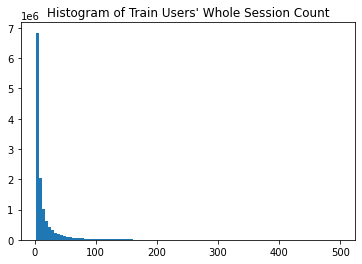

In [9]:
session_cnt = train[['session', 'n']].drop_duplicates()

plt.hist(session_cnt.n.values, bins=100)
plt.title("Histogram of Train Users' Whole Session Count")
m = session_cnt.n.mean()
print(f'The mean session count per train user is {m:0.1f} with right skewed distribution below')
plt.show()

The mean session count per test user is 4.1 with right skewed distribution below


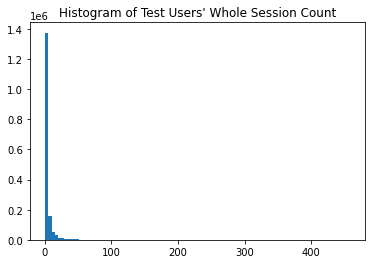

In [10]:
session_cnt = test[['session', 'n']].drop_duplicates()

plt.hist(session_cnt.n.values, bins=100)
plt.title("Histogram of Test Users' Whole Session Count")
m = session_cnt.n.mean()
print(f'The mean session count per test user is {m:0.1f} with right skewed distribution below')
plt.show()

# Session

In [11]:
train_session_lens = train.session.value_counts()

In [17]:
len(train_session_lens[train_session_lens == 1]) / len(train_session_lens)

0.0

In [18]:
len(train_session_lens[train_session_lens == 2]) / len(train_session_lens)

0.19335098686574398

In [19]:
test_session_lens = test.session.value_counts()

In [20]:
len(test_session_lens[test_session_lens == 1]) / len(test_session_lens)

0.44867666824380625

In [21]:
test.loc[test.session.isin(test_session_lens[test_session_lens == 1].index.tolist())]['type'].value_counts()

type
0    748845
1       909
2       345
Name: count, dtype: int64

In [22]:
# split session with actions occuring more than 2h later into subsessions
def create_subsessions_id(df, interval=60*60*2):
    # converte to seconds
    df.ts = df.ts.astype('int64')/1e9
    df = df.sort_values(['session','ts']).reset_index(drop=True)
    df['d'] = df.ts.diff()
    df.loc[ df.session.diff()!=0, 'd'] = 0
    df.d = (df.d > interval).astype('int8').fillna(0)
    df['d'] = df.groupby('session').d.cumsum()
    df.ts = pd.to_datetime(df.ts * 1e9)
    return df

In [23]:
train = create_subsessions_id(train)
test = create_subsessions_id(test)

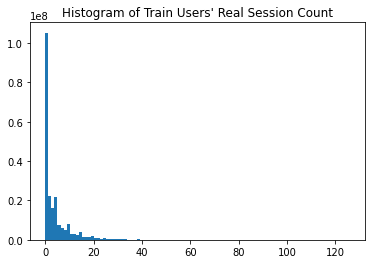

In [24]:
plt.hist(train.d.values, bins=100)
plt.title("Histogram of Train Users' real Session Count")
plt.show()

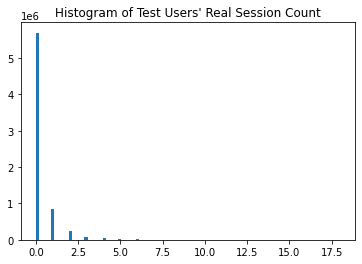

In [25]:
plt.hist(test.d.values, bins=100)
plt.title("Histogram of Test Users' real Session Count")
plt.show()

# Display User and Sessions Time Series

ref: https://www.kaggle.com/code/cdeotte/time-series-eda-users-and-real-sessions

Most users are active during the waking hours of day but some users like to shop during the night while others are sleeping. 

In [46]:
import matplotlib.patches as mpatches

def display_session(df, session):
    colors = np.array( [(0,0,1),(1,0.5,0),(1,0,0)] )
    tmp = df.loc[df.session==session].copy()
    ss = tmp.d.max()+1  # sub sessions count
    ii = len(tmp)       # actions count
    
    plt.figure(figsize=(20,5))
    for j in [0,1,2]:
        s = 25
        if j==1: s=50
        elif j==2: s=100
        tmp2 = tmp.loc[tmp['type']==j]
        xx = np.random.uniform(-0.3,0.3,len(tmp2))
        yy = np.random.uniform(-0.5,0.5,len(tmp2))
        plt.scatter(tmp2.day.values+xx, tmp2.hour.values+yy, s=s, c=colors[tmp2['type'].values])
    plt.ylim((0,24))
    plt.xlim((0,35))
    c1 = mpatches.Patch(color=colors[0], label='Click')
    c2 = mpatches.Patch(color=colors[1], label='Cart')
    c3 = mpatches.Patch(color=colors[2], label='Order')
    plt.plot([0,35],[6-0.5,6-0.5],'--',color='gray')
    plt.plot([0,35],[21+0.5,21+0.5],'--',color='gray')
    for k in range(0,35):
        plt.plot([k+0.5,k+0.5],[0,24],'--',color='gray')
    for k in range(1,5):
        plt.plot([7*k+0.5,7*k+0.5],[0,24],'--',color='black')
    plt.legend(handles=[c1,c2,c3])
    plt.xlabel('Day of August 2022',size=16)
    plt.xticks([1,7,14,21,28,35],['Mon\nAug 1st','Mon\nAug 8st','Mon\nAug 15st','Mon\nAug 22st','Mon\nAug 29st', 'Mon\nSep 5th'])
    plt.ylabel('Hour of Day',size=16)
    plt.yticks([0,4,8,12,16,20,24],['midnight','4am','8am','noon','4pm','8pm','midnight'])
    plt.title(f'User {session} has {ss} real sessions with {ii} item interactions',size=18)
    plt.show()
    print('\n\n')

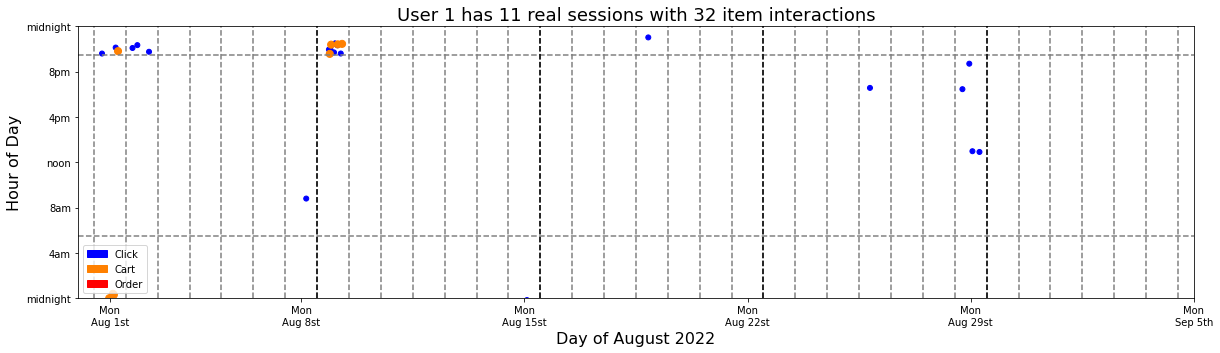

In [47]:
display_session(train, 1)

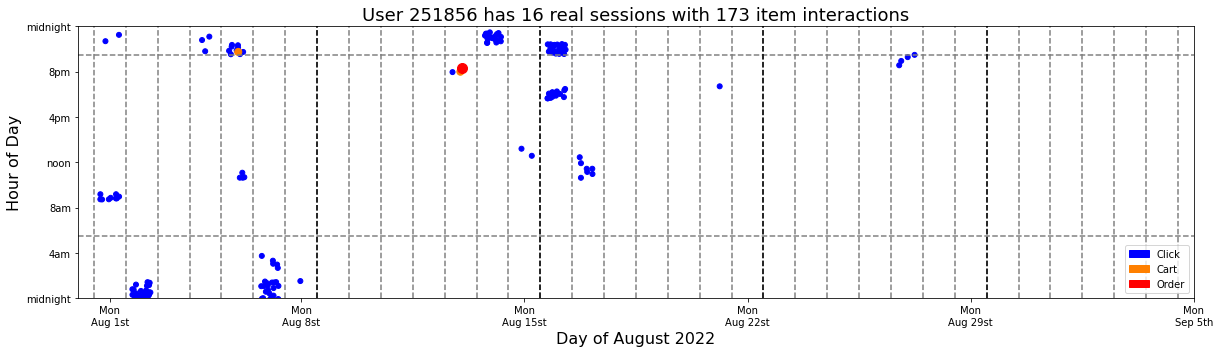

In [48]:
display_session(train, 251856)

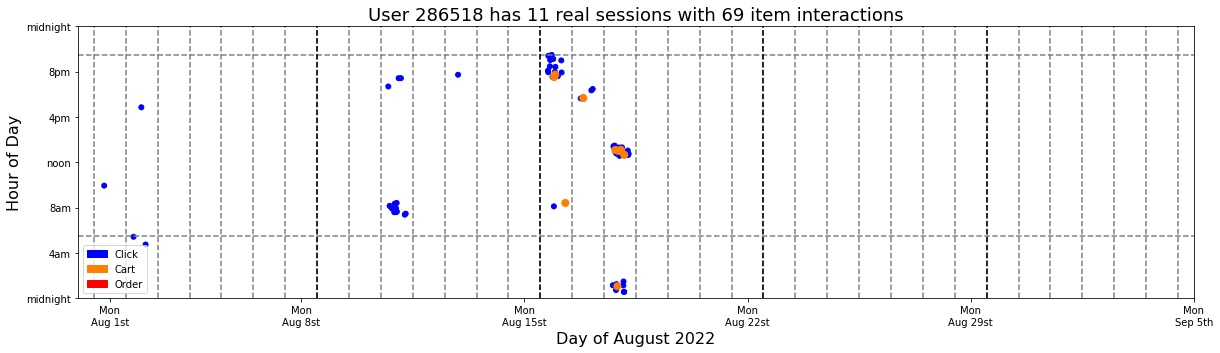

In [49]:
display_session(train, 286518)

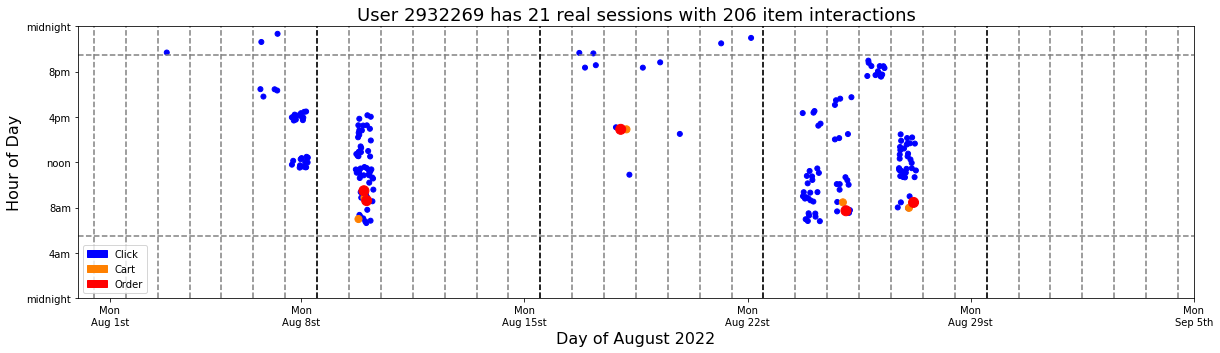

In [50]:
display_session(train, 2932269)

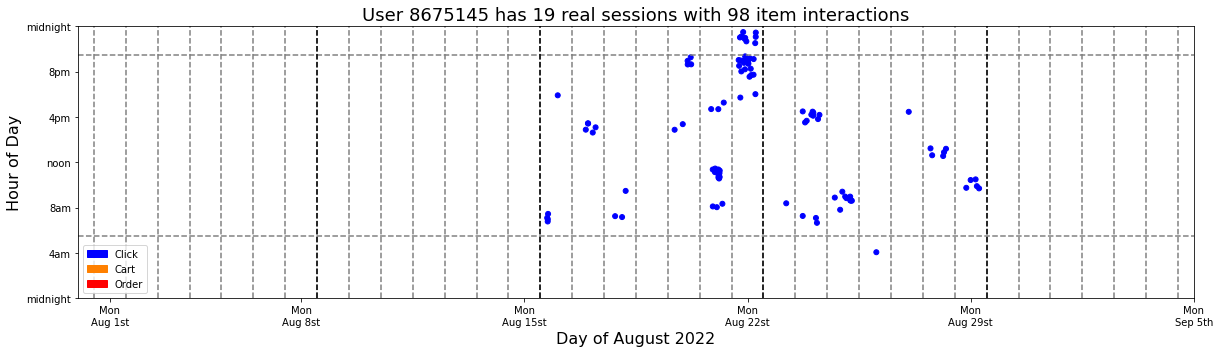

In [51]:
display_session(train, 8675145)

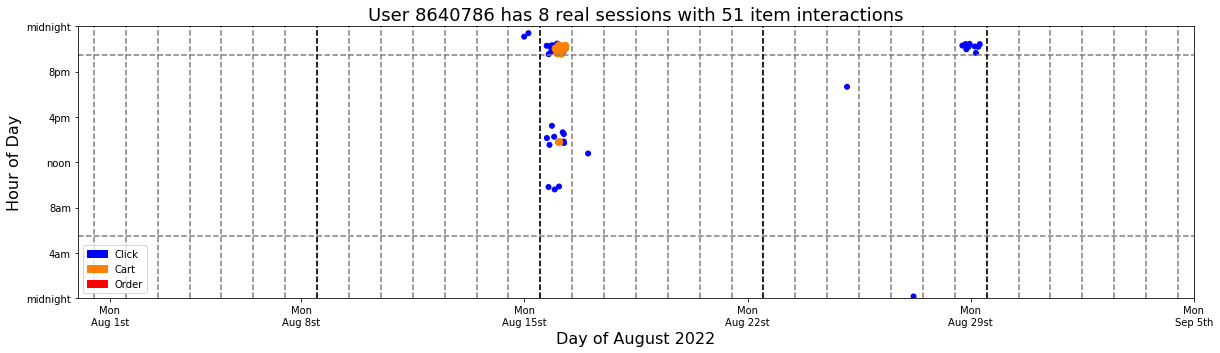

In [52]:
display_session(train, 8640786)

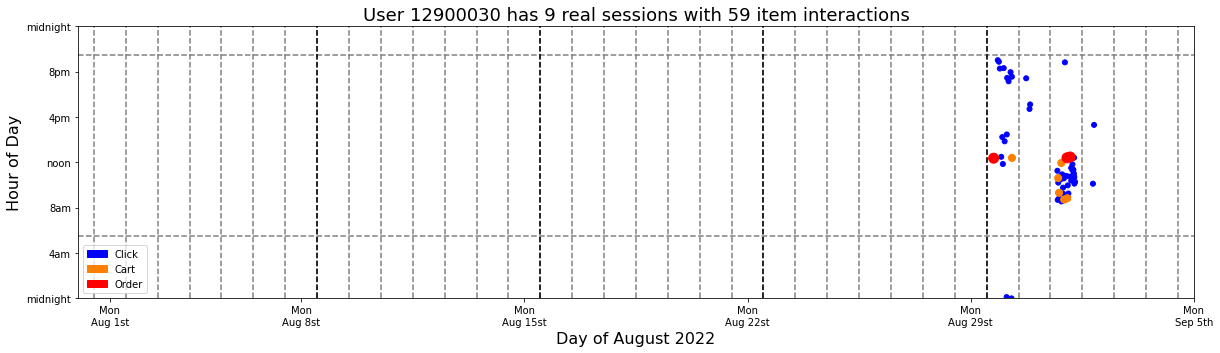

In [53]:
display_session(test,12900030)

## Trending AID

### click/cart/order top20

In [54]:
aid_click_freq = train.loc[train.type == 0].aid.value_counts()
aid_cart_freq = train.loc[train.type == 1].aid.value_counts()
aid_order_freq = train.loc[train.type == 2].aid.value_counts()

<AxesSubplot:title={'center':'order top 20'}, xlabel='aid'>

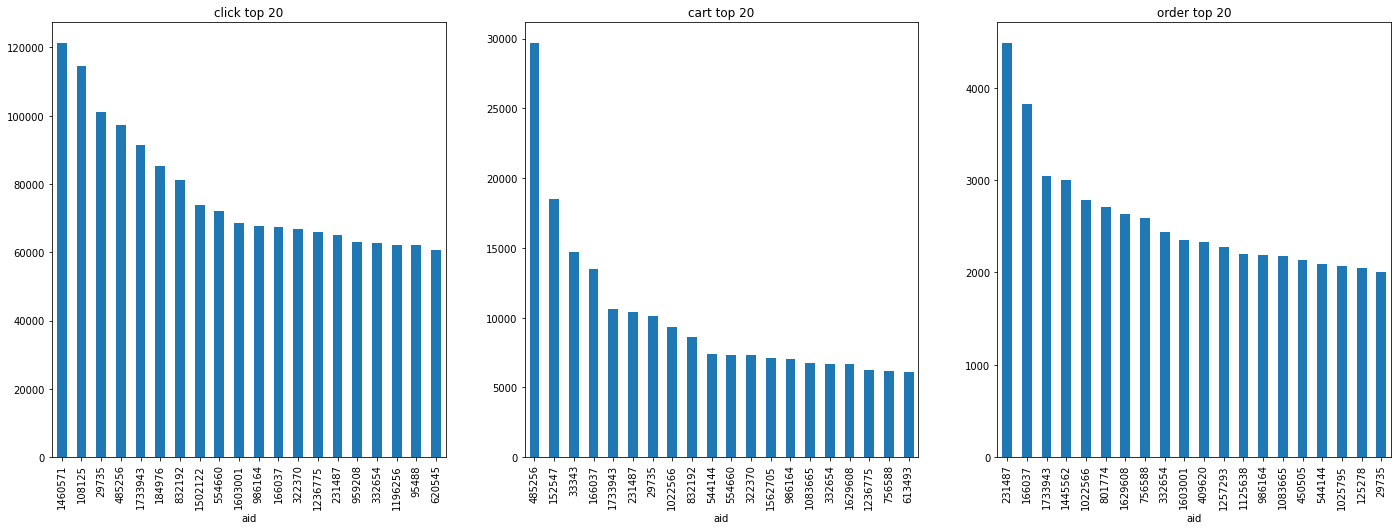

In [55]:
f, axes = plt.subplots(1, 3, figsize=(24, 8))

aid_click_freq.head(20).plot(kind='bar', ax=axes[0], title='click top 20')
aid_cart_freq.head(20).plot(kind='bar', ax=axes[1], title='cart top 20')
aid_order_freq.head(20).plot(kind='bar', ax=axes[2], title='order top 20')

In [56]:
print(f"click top20 ratio : {aid_click_freq.head(20).sum() / aid_click_freq.sum() * 100:.2f}%")
print(f"cart  top20 ratio : {aid_cart_freq.head(20).sum() / aid_cart_freq.sum() * 100:.2f}%")
print(f"order top20 ratio : {aid_order_freq.head(20).sum() / aid_order_freq.sum() * 100:.2f}%")

click top20 ratio : 0.80%
cart  top20 ratio : 1.19%
order top20 ratio : 1.01%


### click/cart/order correlation

In [57]:
aid_stat = pd.concat([
    aid_click_freq.rename("click_freq"),
    aid_cart_freq.rename("cart_freq"),
    aid_order_freq.rename("order_freq")
], axis=1)

In [58]:
aid_stat.corr()

,click_freq,cart_freq,order_freq
click_freq,1.000000,0.786921,0.690620
cart_freq,0.786921,1.000000,0.939723
order_freq,0.690620,0.939723,1.000000


### Avg action interval

In [66]:
import numpy as np
# sample 1% of data for action analysis
sub_sessions = np.random.choice(train.session.unique(), train.session.nunique() // 100, replace=False)
sub_train = train.loc[train.session.isin(sub_sessions)].reset_index(drop=True)

In [67]:
sub_train.groupby("session").apply(lambda g: g.ts.diff(1).median()).median()

Timedelta('0 days 00:01:21')

### Avg click interval

In [63]:
sub_train[sub_train.type == 0].groupby("session").apply(lambda g: g.ts.diff(1).median()).median()

Timedelta('0 days 00:01:35.500000')

### Avg cart interval

In [64]:
sub_train[sub_train.type == 1].groupby("session").apply(lambda g: g.ts.diff(1).dropna().median()).dropna().mean()

Timedelta('0 days 23:29:49.837810254')

###  Avg order interval

In [68]:
sub_train[sub_train.type == 2].groupby("session").apply(lambda g: g.ts.diff(1).dropna().median()).dropna().mean()

Timedelta('1 days 08:59:20.379043677')